In [1]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from proj1_helpers import *
from data_cleaning import *
import implementations as imp
import plots
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

COLUMN_TO_DROP = 22

# Import data

In [2]:
y_train, x_train, ids_train = load_csv_data("../data/train.csv")
y_test, x_test, ids_test = load_csv_data("../data/test.csv")

In [3]:
x_train.shape

(250000, 30)

# Clean data and add features

In [4]:
PRI_jet_num = np.array([x_train[:, COLUMN_TO_DROP]])
print(PRI_jet_num.shape)
del_x_train = np.delete(x_train, COLUMN_TO_DROP, axis=1)
print(del_x_train.shape)

print()

replaced_x_train = replace_undefined(del_x_train, UNDEFINED_VALUE, 0.0)
poly_x_train = create_poly_features(replaced_x_train, 3)
print(poly_x_train[0][0])
print(poly_x_train.shape)

print()

norm_x_train, train_data_mean, train_data_std = mean_std_normalization(poly_x_train)
print(norm_x_train[0][0])
print(norm_x_train.shape)

print()

new_x_train = np.concatenate((norm_x_train, PRI_jet_num.T), axis=1)
print(new_x_train.shape)

(1, 250000)
(250000, 29)

138.47
(250000, 87)

0.4986371179215161
(250000, 87)

(250000, 88)


# Do the same for the test data

In [5]:
PRI_jet_num = np.array([x_test[:, COLUMN_TO_DROP]])
print(PRI_jet_num[0:5])
print(PRI_jet_num.shape)
del_x_test = np.delete(x_test, COLUMN_TO_DROP, axis=1)
print(del_x_train.shape)

replaced_x_test = replace_undefined(del_x_test, UNDEFINED_VALUE, 0.0)
poly_x_test = create_poly_features(replaced_x_test, 3)
print(poly_x_test[0][0])
print(poly_x_test.shape)

norm_x_test, test_data_mean, test_data_std = mean_std_normalization(poly_x_test, train_data_mean, train_data_mean)
print(norm_x_test[0][0])
print(norm_x_test.shape)

new_x_test = np.concatenate((norm_x_test, PRI_jet_num.T), axis=1)
print(new_x_test.shape)

[[0. 1. 0. ... 0. 1. 0.]]
(1, 568238)
(250000, 29)
0.0
(568238, 87)
-1.0096823731792868
(568238, 87)
(568238, 88)


# Make and train model
### GD

In [6]:
gamma = 0.1
max_iters = 100
seed = 1
ratio = 0.8
initial_w = np.zeros(new_x_train.shape[1], dtype=np.float64)

# Traning and validation set
# If we want to use this we need to change the gradient implementation....
# It needs to test the model in each iteration and return the % of correct prediction for each iteration
# The same goes for SGD
(tr_x, tr_y, val_x, val_y) = split_data(new_x_train, y_train, ratio, seed)

# Training
gd_loss, gd_weights = imp.least_squares_GD(tr_y, tr_x, initial_w, max_iters, gamma)

In [7]:
print(gd_loss)

8.242136460464226e+135


### Testing

In [73]:
y_pred = predict_labels(gd_weights[-1], new_x_test)
n = len(y_pred)
correct = 0
for i in range(n):
    if (y_pred[i] == y_test[i]):
        correct += 1
print(str(correct) + " of " + str(n) + " correct, precentage: " + str(correct/n)) 

284565 of 568238 correct, precentage: 0.5007848823908292


### SGD

In [86]:
gamma = 0.1
max_iters = 50
initial_w = np.zeros(new_x_train.shape[1], dtype=np.float64)
batch_size = int(np.floor(new_x_train.shape[0] / 100))

# Training
sgd_loss, sgd_weights = imp.least_squares_SGD(y_train, new_x_train, initial_w, max_iters, gamma, batch_size)

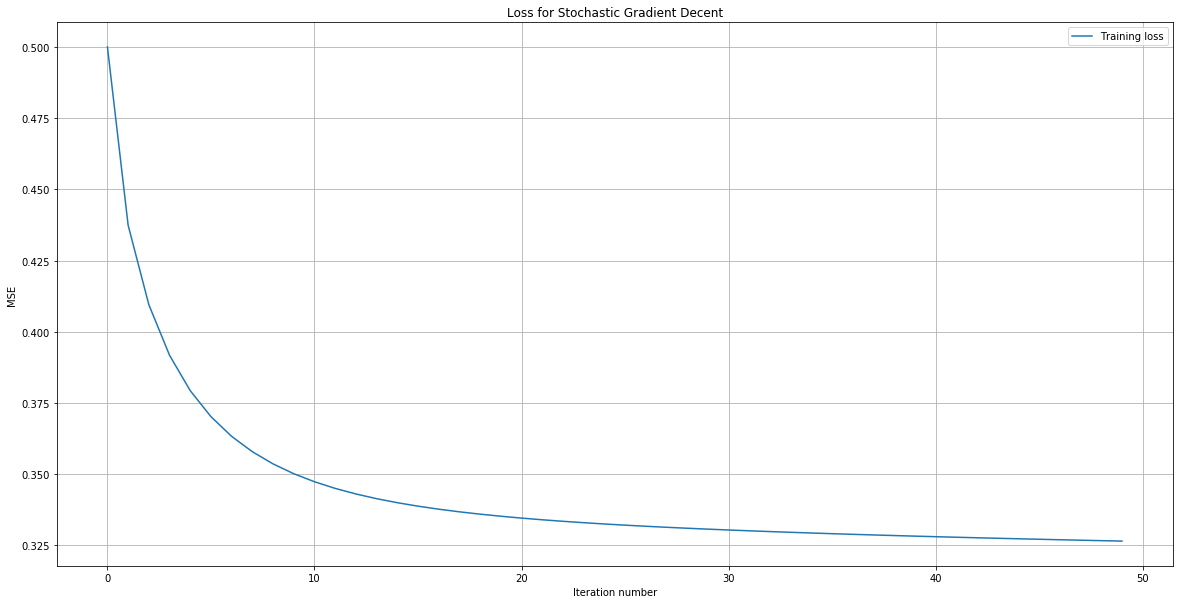

In [88]:
# Plot
plt.subplots(figsize=(20,10))
plt.plot(sgd_loss)
plt.legend(["Training loss"])
plt.grid()
plt.title("Loss for Stochastic Gradient Decent")
plt.xlabel("Iteration number")
plt.ylabel("MSE")
plt.show()

### Testing

In [89]:
y_pred = predict_labels(sgd_weights[-1], new_x_test)
n = len(y_pred)
correct = 0
for i in range(n):
    if (y_pred[i] == y_test[i]):
        correct += 1
print(str(correct) + " of " + str(n) + " correct, precentage: " + str(correct/n)) 

280737 of 568238 correct, precentage: 0.49404826850721
